In [2]:
import numpy as np
import pandas as pd
import scipy as sp
from scipy.ndimage.filters import gaussian_filter as smooth


%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 16, 9
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)

import fair
from fair.fair_inverse_model import co2_conc_total as rf_to_conc
from fair.fair_inverse_model import annual_emissions_calc2 as conc_to_emissions
from fair.forward import fair_scm as FAIR_model
fair.__version__

ImportError: cannot import name fair_scm

In [2]:
# Using Fair to go RCP3PD emissions -> radiative forcings for CH4 and CO2

C_0 = 279.51
F_2x= 3.71
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332

emms_file = './fair/RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

concs_filem = './fair/GCP_data/RCP3PD_MIDYEAR_CONCENTRATIONS.csv'
concs_datam = np.genfromtxt(concs_filem,skip_header=37,delimiter=',',names=True)
M_concs = concs_datam['CH4']
N_concs = concs_datam['N2O']
concs = concs_datam['CO2']

forc_file = './fair/RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']

#total
C,T,RF,M,N,MK_gas,db,tau_M,tau_N = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CO2
C_co2,T_co2,RF_co2,M_co2,N_co2,MK_gas_co2,db_co2,tau_M_co2,tau_N_co2 = FAIR_model(
                            emissions=emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just CH4
C_ch4,T_ch4,RF_ch4,M_ch4,N_ch4,MK_gas_ch4,db_ch4,tau_M_ch4,tau_N_ch4 = FAIR_model(other_rf = np.zeros(emissions.size),
                            M_emissions=M_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just N2O
C_n2o,T_n2o,RF_n2o,M_n2o,N_n2o,MK_gas_n2o,db_n2o,tau_M_n2o,tau_N_n2o = FAIR_model(other_rf = np.zeros(emissions.size),
                            N_emissions=N_emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#just other
C_other,T_other,RF_other,M_other,N_other,MK_gas_other,db_other,tau_M_other,tau_N_other = FAIR_model(
                            other_rf = other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
    
#anthro total from RCP3 RF datafile    
C_nonono,T_0,RF_0,M_0,N_0,MK_gas_0,db_0,tau_M_0,tau_N_0 = FAIR_model(other_rf=forc_data['TOTAL_ANTHRO_RF'],
                            N_0=270.0,MAGICC_model = True,S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

# NB. the "0" signifier represents radiative forcings entirely NOT calculated by fair (ie. from RCP only)

ANTHRO_RF_0 = smooth(RF_0,5)
ANTHRO_RF = smooth(RF,5)
CH4_RF = smooth(RF_ch4,5)
N2O_RF = smooth(RF_n2o,5)
CO2_RF = smooth(RF_co2,5)
other_RF = smooth(RF_other,5)

In [3]:
ANTHRO_conc = rf_to_conc(ANTHRO_RF, a = F_2x/np.log(2) , Cpreind = C_0)
CH4_conc = rf_to_conc(CH4_RF, a = F_2x/np.log(2) , Cpreind = C_0)
CO2_conc = rf_to_conc(CO2_RF, a = F_2x/np.log(2) , Cpreind = C_0)
N2O_conc = rf_to_conc(N2O_RF, a = F_2x/np.log(2) , Cpreind = C_0)
other_conc = rf_to_conc(other_RF, a = F_2x/np.log(2), Cpreind = C_0)

ANTHRO_conc_0 = rf_to_conc(ANTHRO_RF_0, a = F_2x/np.log(2) , Cpreind = C_0)

In [4]:
anthro_CO2_fe_emms = conc_to_emissions(ANTHRO_conc,T,year_smoothing=0, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CH4_CO2_fe_emms = conc_to_emissions(CH4_conc,T_ch4,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
CO2_CO2_fe_emms = conc_to_emissions(CO2_conc,T_co2,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
N2O_CO2_fe_emms = conc_to_emissions(N2O_conc,T_n2o,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.
other_CO2_fe_emms = conc_to_emissions(other_conc,T_other,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

anthro_CO2_fe_emms_0 = conc_to_emissions(ANTHRO_conc_0,T_0,year_smoothing=0,pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0) * 44./12.

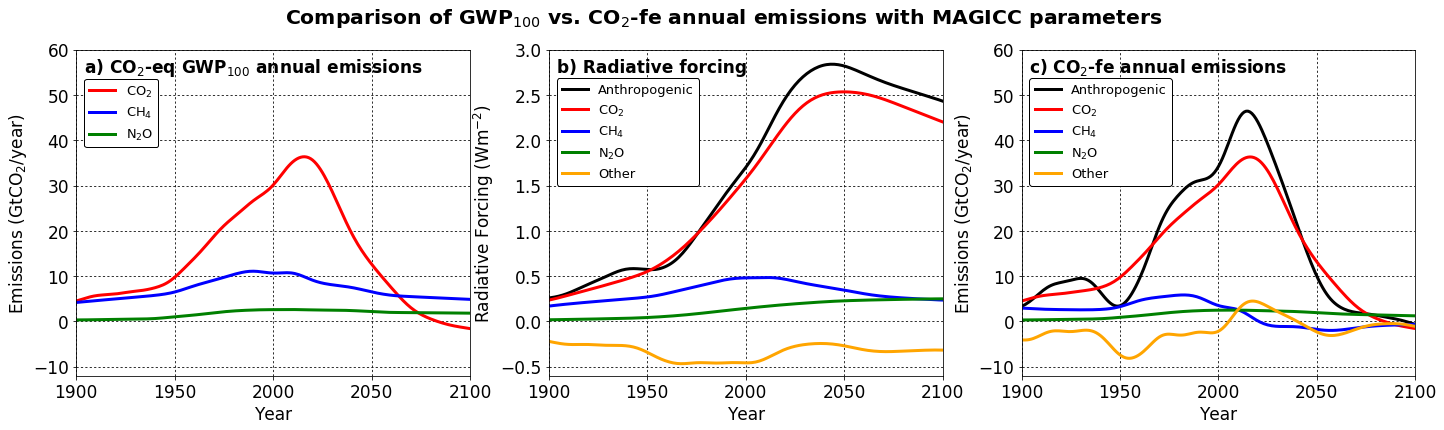

In [10]:
time = np.arange(1765,2501)

CO2_emissions = emissions * 44./12.
CH4_CO2_eq_GWP = M_emissions * 34./1000.
N2O_CO2_eq_GWP = N_emissions * 298./1000.

cum_CO2_fe = np.cumsum(CO2_CO2_fe_emms)
cum_CH4_fe = np.cumsum(CH4_CO2_fe_emms)
cum_N2O_fe = np.cumsum(N2O_CO2_fe_emms)
cum_anthro_fe = np.cumsum(anthro_CO2_fe_emms)
cum_other_fe = np.cumsum(other_CO2_fe_emms)

cum_anthro_fe_0 = np.cumsum(anthro_CO2_fe_emms_0)

# Smoothing

CO2_emissions_smooth = smooth(CO2_emissions,5)
CH4_CO2_eq_GWP_smooth = smooth(CH4_CO2_eq_GWP,5)
N2O_CO2_eq_GWP_smooth = smooth(N2O_CO2_eq_GWP,5)
cum_CO2_emms_GWP = np.cumsum(CO2_emissions_smooth)
cum_CH4_emms_GWP = np.cumsum(CH4_CO2_eq_GWP_smooth)
cum_N2O_emms_GWP = np.cumsum(N2O_CO2_eq_GWP_smooth)

fig = plt.figure(figsize=(24,6))
ax1 = fig.add_subplot(131)
ax3 = fig.add_subplot(133)
ax5 = fig.add_subplot(132)

ax1.grid(linestyle = ':',color = 'black')
ax1.text(1904,55,'a) CO$_2$-eq GWP$_{100}$ annual emissions', fontweight = 'bold')
ax1.plot(time,CO2_emissions_smooth,label='CO$_2$',color='red')
ax1.plot(time,CH4_CO2_eq_GWP_smooth,label='CH$_4$',color='blue')
ax1.plot(time,N2O_CO2_eq_GWP_smooth,label='N$_2$O',color='green')
ax1.set_ylabel('Emissions (GtCO$_2$/year)')
ax1.set_xlabel('Year')
ax1.legend(loc=(0.02,0.7),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax1.set_xlim(1900,2100)
ax1.set_ylim(-12.,60.)

ax3.grid(linestyle = ':',color = 'black')
ax3.text(1904,55,'c) CO$_2$-fe annual emissions', fontweight = 'bold')
ax3.plot(time,anthro_CO2_fe_emms_0,label='Anthropogenic',color='black')
ax3.plot(time,CO2_CO2_fe_emms,label='CO$_2$',color='red')
ax3.plot(time,CH4_CO2_fe_emms,label='CH$_4$',color='blue')
ax3.plot(time,N2O_CO2_fe_emms,label='N$_2$O',color='green')
ax3.plot(time,other_CO2_fe_emms,label='Other',color='orange')
ax3.set_xlabel('Year')
ax3.set_ylabel('Emissions (GtCO$_2$/year)')
ax3.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax3.set_xlim(1900,2100)
ax3.set_ylim(-12.,60.)

ax5.grid(linestyle = ':',color = 'black')
ax5.text(1904,2.75,'b) Radiative forcing', fontweight = 'bold')
ax5.plot(time,ANTHRO_RF_0,label='Anthropogenic',color='black')
ax5.plot(time,CO2_RF,label='CO$_2$',color='red')
ax5.plot(time,CH4_RF,label='CH$_4$',color='blue')
ax5.plot(time,N2O_RF,label='N$_2$O',color='green')
ax5.plot(time,other_RF,label='Other',color='orange')
ax5.set_xlabel('Year')
ax5.set_ylabel('Radiative Forcing (Wm$^{-2}$)')
ax5.legend(loc=(0.02,0.583),framealpha = 1,shadow = False,edgecolor = 'black',fontsize=13 )
ax5.set_xlim(1900,2100)
ax5.set_ylim(-0.6,3.0)

#fig.suptitle('Comparison of GWP$_{100}$ vs. CO$_2$-fe annual emissions with MAGICC parameters', fontweight = 'bold')

#fig.savefig('./Figures/CO2-e vs CO2-fe Figure_MAGICC_params_adding.png',dpi=600)

In [2]:
import numpy as np
import  fair_inverse_revised
from forward_multiple_GHG import fair_scm as FAIR_model
from scipy.ndimage.filters import gaussian_filter as smooth

%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['lines.linewidth'] = 3

font = {'weight' : 'normal',
      'size'   : 17}

plt.rc('font', **font)

#parameter set and import data
C_0 = 279.51
F_2x= 3.71
a = np.array([0.05,0.236489403703,0.3,0.413510596297])
r0 = 39.1193644809
rC=0.0152
rT=3.332

emms_file = './RCPs/RCP3PD_EMISSIONS.csv'
emms_data = np.genfromtxt(emms_file,skip_header=36,delimiter=',',names=True)

emissions = emms_data['FossilCO2'] + emms_data['OtherCO2']
M_emissions = emms_data['CH4']
N_emissions = emms_data['N2O'] * 44.0 / 28.0 * 0.73

forc_file = './RCPs/RCP3PD_MIDYEAR_RADFORCING.csv'
forc_data = np.genfromtxt(forc_file,skip_header=58,delimiter=',',names=True)
other_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CO2_RF'] - forc_data['CH4_RF'] - forc_data['N2O_RF']
#---------------

#total
out_total = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#co2 only
out_co2_only = FAIR_model(emissions=emissions,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus ch4
out_total_minus_ch4 = FAIR_model(emissions=emissions,N_emissions = N_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus n2o
out_total_minus_n2o = FAIR_model(emissions=emissions,M_emissions=M_emissions,
                            other_rf=other_rf,N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#total minus other
out_total_minus_other = FAIR_model(emissions=emissions,M_emissions=M_emissions,N_emissions = N_emissions,
                            N_0=270.0,MAGICC_model = True,
                            S_OH_CH4 = -0.32, S_T_CH4 = 0.035, tau_M_0 = 9.0,
                            F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#-----------

#smooth rf inputs
out_total['forcing']['total'] = smooth(out_total['forcing']['total'],10)
out_total_minus_ch4['forcing']['total'] = smooth(out_total_minus_ch4['forcing']['total'],10)
out_total_minus_n2o['forcing']['total'] = smooth(out_total_minus_n2o['forcing']['total'],10)
out_total_minus_other['forcing']['total'] = smooth(out_total_minus_other['forcing']['total'],10)
out_co2_only['forcing']['total'] = smooth(out_co2_only['forcing']['total'],10)


#-----------
total_conc = fair_inverse_revised.forcing_to_conc(out_total['forcing']['total'], a = F_2x/np.log(2) , Cpreind = C_0)
total_temp = out_total['temperature']
total_ems, total_ems_smooth = fair_inverse_revised.conc_to_emissions(total_conc, total_temp, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

co2_conc = fair_inverse_revised.forcing_to_conc(out_co2_only['forcing']['total'], a = F_2x/np.log(2) , Cpreind = C_0)
co2_temp = out_co2_only['temperature']
co2_ems, co2_ems_smooth = fair_inverse_revised.conc_to_emissions(co2_conc, co2_temp, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

total_minus_ch4_conc = fair_inverse_revised.forcing_to_conc(out_total_minus_ch4['forcing']['total'], a = F_2x/np.log(2) , Cpreind = C_0)
total_minus_ch4_temp = out_total_minus_ch4['temperature']
total_minus_ch4_ems, total_minus_ch4_ems_smooth = fair_inverse_revised.conc_to_emissions(total_minus_ch4_conc, total_minus_ch4_temp, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ch4_ems = total_ems - total_minus_ch4_ems

total_minus_n2o_conc = fair_inverse_revised.forcing_to_conc(out_total_minus_n2o['forcing']['total'], a = F_2x/np.log(2) , Cpreind = C_0)
total_minus_n2o_temp = out_total_minus_n2o['temperature']
total_minus_n2o_ems, total_minus_n2o_ems_smooth = fair_inverse_revised.conc_to_emissions(total_minus_n2o_conc, total_minus_n2o_temp, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
n2o_ems = total_ems - total_minus_n2o_ems

total_minus_other_conc = fair_inverse_revised.forcing_to_conc(out_total_minus_other['forcing']['total'], a = F_2x/np.log(2) , Cpreind = C_0)
total_minus_other_temp = out_total_minus_other['temperature']
total_minus_other_ems, total_minus_other_ems_smooth = fair_inverse_revised.conc_to_emissions(total_minus_other_conc, total_minus_other_temp, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
other_ems = total_ems - total_minus_other_ems

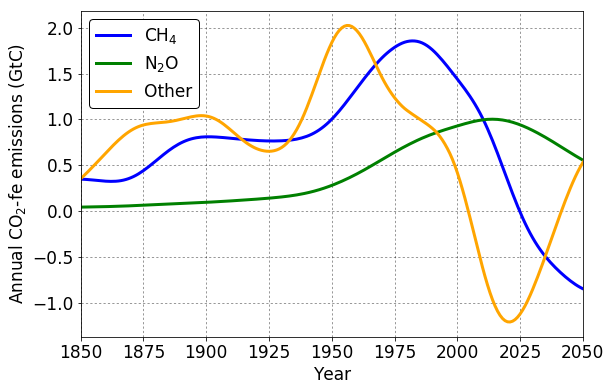

In [3]:
#plt.plot(np.arange(1765,2501), total_ems, color = 'black', label = 'Total anthro')
#plt.plot(np.arange(1765,2501), co2_ems, color = 'red', label = 'CO$_2$')
plt.plot(np.arange(1765,2501), ch4_ems, color = 'blue', label = 'CH$_4$')
plt.plot(np.arange(1765,2501), n2o_ems, color = 'green', label = 'N$_2$O')
plt.plot(np.arange(1765,2501), -1.*other_ems, color = 'orange', label = 'Other')
plt.xlim(1850,2050)
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC)')
plt.legend(loc = 'best', framealpha = 1, edgecolor = 'black')

In [4]:
# calculating co2-fe emissions for components using differencing approach and the RCP3PD rf data

anthro_rf = forc_data['TOTAL_ANTHRO_RF']
co2_rf = forc_data['CO2_RF']
anthro_minus_ch4_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['CH4_RF']
anthro_minus_n2o_rf = forc_data['TOTAL_ANTHRO_RF'] - forc_data['N2O_RF']
anthro_minus_kyoto_rf = forc_data['TOTAL_ANTHRO_RF'] -  forc_data['FGASSUM_RF']
anthro_minus_montreal_rf = forc_data['TOTAL_ANTHRO_RF'] -  forc_data['MHALOSUM_RF']
anthro_minus_diraer_rf = forc_data['TOTAL_ANTHRO_RF'] -  forc_data['TOTAER_DIR_RF']
anthro_minus_ch4ox_rf = forc_data['TOTAL_ANTHRO_RF'] -  forc_data['CH4OXSTRATH2O_RF']
anthro_minus_ozone_rf = forc_data['TOTAL_ANTHRO_RF'] -  forc_data['STRATOZ_RF'] -  forc_data['TROPOZ_RF']

conc_anthro_rf = fair_inverse_revised.forcing_to_conc(anthro_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_co2_rf = fair_inverse_revised.forcing_to_conc(co2_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_ch4_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_ch4_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_n2o_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_n2o_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_kyoto_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_kyoto_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_montreal_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_montreal_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_diraer_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_diraer_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_ch4ox_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_ch4ox_rf, a = F_2x/np.log(2) , Cpreind = C_0)
conc_anthro_minus_ozone_rf = fair_inverse_revised.forcing_to_conc(anthro_minus_ozone_rf, a = F_2x/np.log(2) , Cpreind = C_0)

#-------------

from forward_original import fair_scm as FAIR
C_1, T_anthro_rf, RF_0 = FAIR(other_rf=anthro_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_co2_rf, RF_0 = FAIR(other_rf=co2_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_ch4_rf, RF_0 = FAIR(other_rf=anthro_minus_ch4_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_n2o_rf, RF_0 = FAIR(other_rf=anthro_minus_n2o_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_kyoto_rf, RF_0 = FAIR(other_rf=anthro_minus_kyoto_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_montreal_rf, RF_0 = FAIR(other_rf=anthro_minus_montreal_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_diraer_rf, RF_0 = FAIR(other_rf=anthro_minus_diraer_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_ch4ox_rf, RF_0 = FAIR(other_rf=anthro_minus_ch4ox_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
C_1, T_anthro_minus_ozone_rf, RF_0 = FAIR(other_rf=anthro_minus_ozone_rf, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)

#-------------
ems_anthro_rf, ems_anthro_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_rf, T_anthro_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_co2_rf, ems_co2_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_co2_rf, T_co2_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

ems_anthro_minus_ch4_rf, ems_anthro_minus_ch4_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_ch4_rf, T_anthro_minus_ch4_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_ch4_smooth = ems_anthro_rf_smooth - ems_anthro_minus_ch4_rf_smooth

ems_anthro_minus_n2o_rf, ems_anthro_minus_n2o_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_n2o_rf, T_anthro_minus_n2o_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_n2o_smooth = ems_anthro_rf_smooth - ems_anthro_minus_n2o_rf_smooth

ems_anthro_minus_kyoto_rf, ems_anthro_minus_kyoto_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_kyoto_rf, T_anthro_minus_kyoto_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_kyoto_smooth = ems_anthro_rf_smooth - ems_anthro_minus_kyoto_rf_smooth

ems_anthro_minus_montreal_rf, ems_anthro_minus_montreal_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_montreal_rf, T_anthro_minus_montreal_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_montreal_smooth = ems_anthro_rf_smooth - ems_anthro_minus_montreal_rf_smooth

ems_anthro_minus_diraer_rf, ems_anthro_minus_diraer_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_diraer_rf, T_anthro_minus_diraer_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_diraer_smooth = ems_anthro_rf_smooth - ems_anthro_minus_diraer_rf_smooth

ems_anthro_minus_ch4ox_rf, ems_anthro_minus_ch4ox_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_ch4ox_rf, T_anthro_minus_ch4ox_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_ch4ox_smooth = ems_anthro_rf_smooth - ems_anthro_minus_ch4ox_rf_smooth

ems_anthro_minus_ozone_rf, ems_anthro_minus_ozone_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_anthro_minus_ozone_rf, T_anthro_minus_ozone_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)
ems_ozone_smooth = ems_anthro_rf_smooth - ems_anthro_minus_ozone_rf_smooth

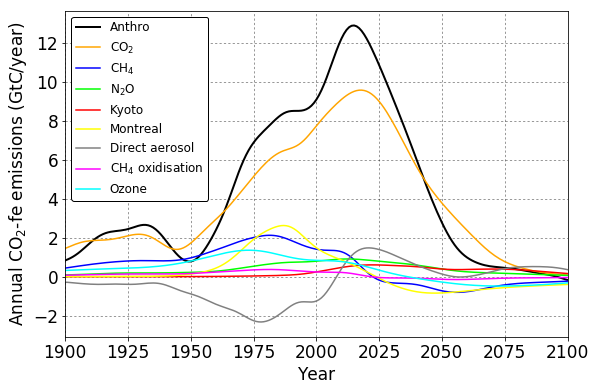

In [9]:
#import median data anthro forcing from richard
rf_comps_median = np.loadtxt("Annualforcings_Mar2014_GHGrevised.txt", skiprows=4)
rf_aerosol_piers = rf_comps_median[:,6]
C_1, T_aerosol_rf, RF_0 = FAIR(other_rf=rf_aerosol_piers, F_2x= F_2x, C_0=C_0,a = a,r0 = r0,rC=rC,rT=rT)
conc_aerosol_rf = fair_inverse_revised.forcing_to_conc(rf_aerosol_piers, a = F_2x/np.log(2) , Cpreind = C_0)
ems_aerosol_rf, ems_aerosol_rf_smooth = fair_inverse_revised.conc_to_emissions(conc_aerosol_rf, T_aerosol_rf, pool_splits=a,r0=r0,rC=rC,rT=rT,Cpreind = C_0)

plt.plot(np.arange(1765,2501), ems_anthro_rf_smooth, color = 'black', label = 'Anthro', linewidth = 2)
plt.plot(np.arange(1765,2501), ems_co2_rf_smooth, color = 'orange', label = 'CO$_2$', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_ch4_smooth, color = 'blue', label = 'CH$_4$', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_n2o_smooth, color = 'lime', label = 'N$_2$O', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_kyoto_smooth, color = 'red', label = 'Kyoto', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_montreal_smooth, color = 'yellow', label = 'Montreal', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_diraer_smooth, color = 'gray', label = 'Direct aerosol', linewidth = 1.5)
plt.plot(np.arange(1765,2501), ems_ch4ox_smooth, color = 'magenta', label = 'CH$_4$ oxidisation', linewidth = 1.5)
plt.plot(np.arange(1765,2501), smooth(ems_ozone_smooth,10), color = 'cyan', label = 'Ozone', linewidth = 1.5)
plt.xlim(1900,2100)
plt.grid(True, linestyle = ':', color = 'black', alpha = 0.5)
plt.xlabel('Year')
plt.ylabel('Annual CO$_2$-fe emissions (GtC/year)')
plt.legend(loc = 'upper left', framealpha = 1, edgecolor = 'black', fontsize = 12)
#plt.ylim(-5.5,9)

#plt.savefig('other_co2-fe_ems')